In [1]:
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

In [3]:
import pygmt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

import celeri
celeri = reload(celeri)

# Plotting the global model is much much faster with tex fonts turned off
plt.rcParams['text.usetex'] = False

In [4]:
command_file_name = "./data/western_north_america/basic_command.json"
command, segment, block, meshes, station, mogi, sar = celeri.read_data(command_file_name)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
# celeri.plot_block_labels(segment, block, station, closure)

In [5]:
# celeri.plot_segment_displacements(segment, station, command, segment_idx=0, strike_slip=1, dip_slip=0, tensile_slip=0, lon_min=235, lon_max=255, lat_min=30, lat_max=50, quiver_scale=1e-1)


In [6]:
# Plot TDE displacements from a single element
tri_idx = 0
vel_east, vel_north, vel_up = celeri.get_tri_displacements(station.lon.to_numpy(), station.lat.to_numpy(), meshes, command.material_lambda, command.material_mu, tri_idx=0, strike_slip=1, dip_slip=0, tensile_slip=0)
plt.figure()
plt.plot(meshes[0].lon1[tri_idx], meshes[0].lat1[tri_idx], ".r")
plt.plot(meshes[0].lon2[tri_idx], meshes[0].lat2[tri_idx], ".r")
plt.plot(meshes[0].lon3[tri_idx], meshes[0].lat3[tri_idx], ".r")
plt.quiver(station.lon, station.lat, vel_east, vel_north, scale=1e-3)
plt.show()

/Users/meade/opt/anaconda3/envs/celeri/lib/python3.9/site-packages/cutde/coordinators.py:77: UserWarning: The obs_pts input array has Fortran ordering. Converting to C ordering. This may be expensive.
  warnings.warn(


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

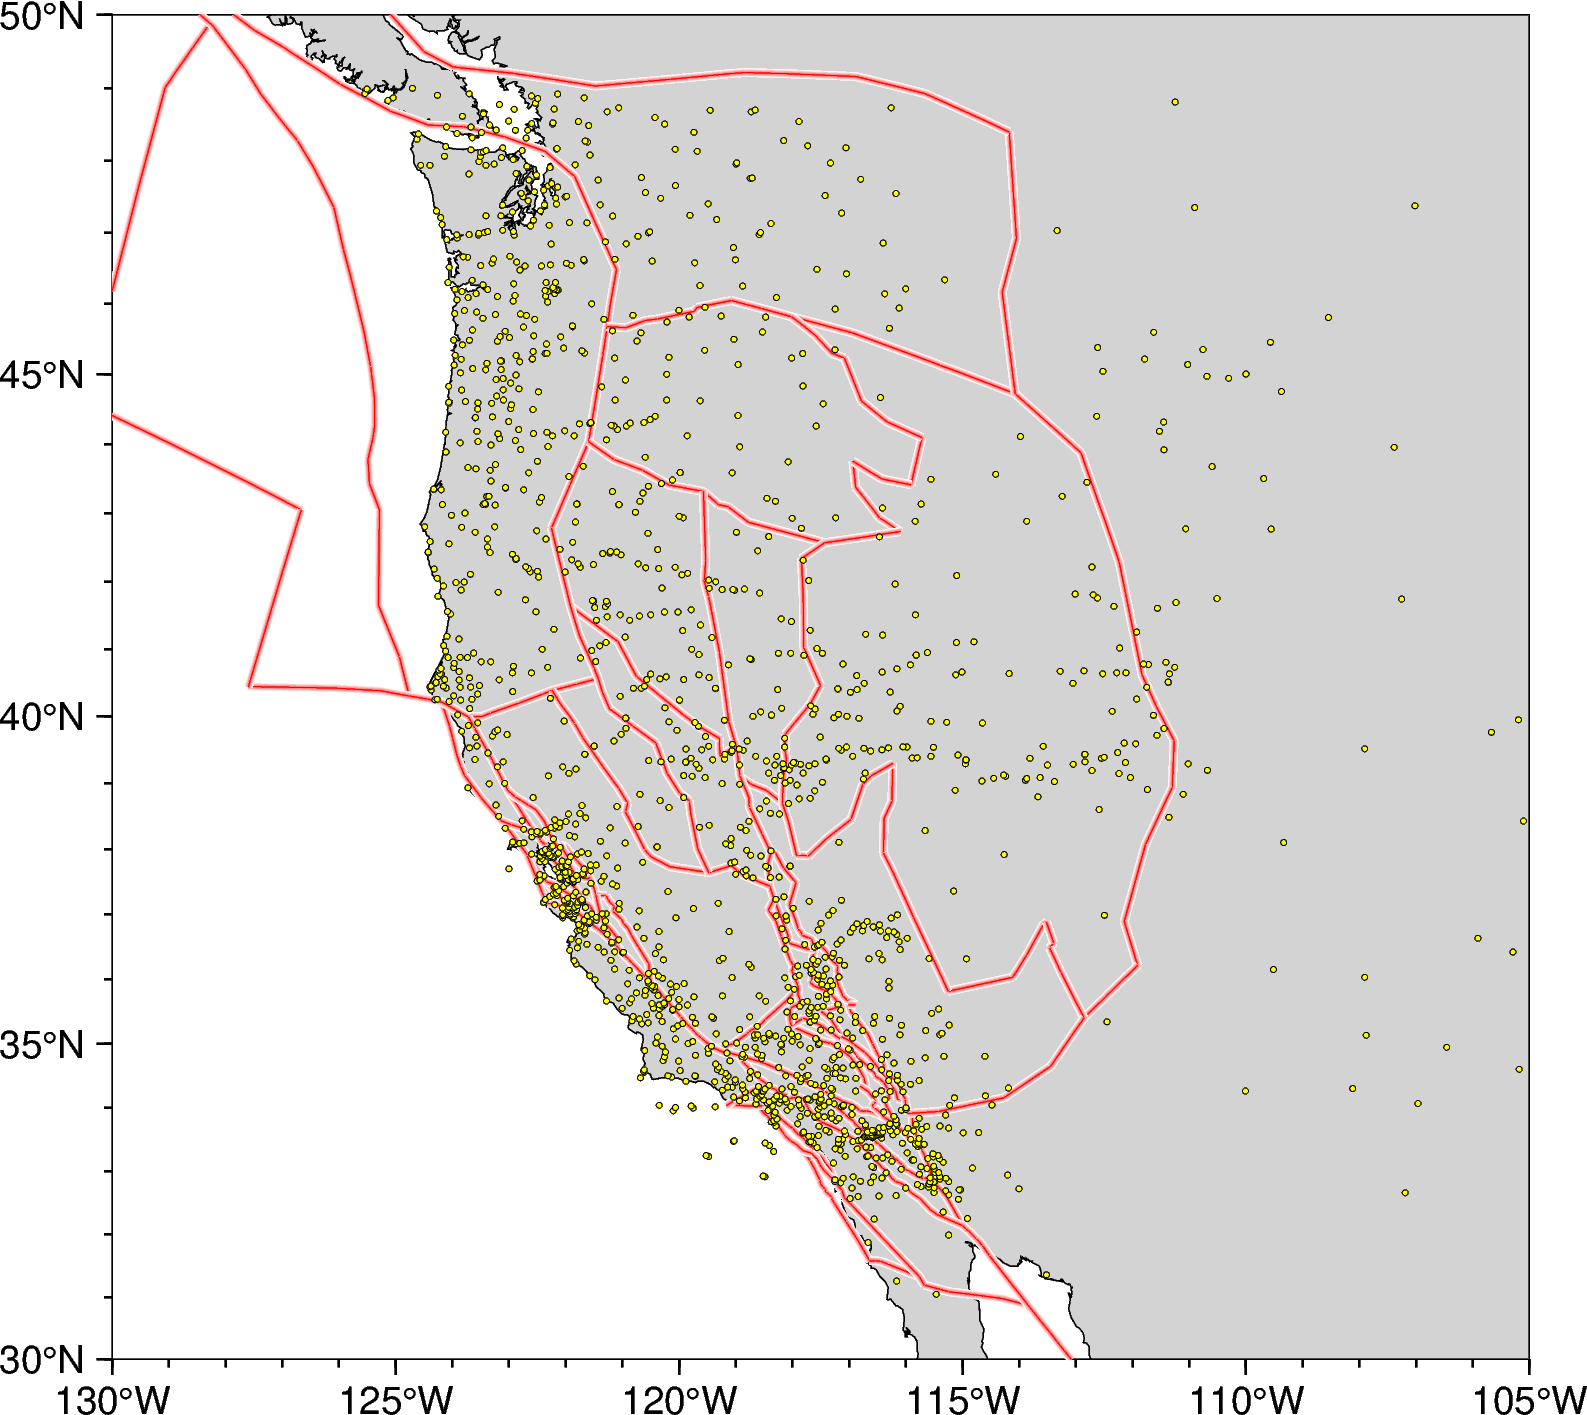

In [92]:
# Create a plot with coast, Miller projection (J) over the continental US
min_lon = -130.0
max_lon = -105.0
min_lat = 30.0
max_lat = 50.0
# topo_data = '@earth_relief_30s'

topo_data = '@earth_relief_01m'

fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
pygmt.config(MAP_FRAME_PEN="0.25p")

pygmt.makecpt(
    cmap='gray',
    series='-20000/4000/2000',
    continuous=True
)

fig.grdimage(
    grid=topo_data,
    region=[min_lon, max_lon, min_lat, max_lat],
    shading=True,
    projection="J-65/12c",
    )

fig.coast(
    region=[-130, -105, 30, 50],
    projection="J-65/12c",
    land="lightgray",
    water="white",
    area_thresh=4000,
    shorelines="0.25p,black",
    frame="p",
)

# Note about transparency:
# http://gmt.soest.hawaii.edu/boards/1/topics/4661

# TODO: Plot polygons rater than individual segments?

n_glow = 10
shading_array = np.linspace(255, 0, n_glow)
shading_array = np.array([255, 245, 230, 210, 190, 170, 150, 130, 110, 0])
pen_width_array = np.linspace(2.0, 0.01, n_glow)
for i in range(len(segment)):
# for i in range(10):
    for j in range(n_glow):
        pen_string = str(pen_width_array[j]) + "p,255/" + str(shading_array[j]) + "/" + str(shading_array[j])
        fig.plot(x=[segment.lon1[i], segment.lon2[i]], y=[segment.lat1[i], segment.lat2[i]], pen=pen_string)    
    # fig.plot(x=[segment.lon1[i], segment.lon2[i]], y=[segment.lat1[i], segment.lat2[i]], pen="3.0p,255/200/200")
    # fig.plot(x=[segment.lon1[i], segment.lon2[i]], y=[segment.lat1[i], segment.lat2[i]], pen="1.0p,255/50/50")
    # fig.plot(x=[segment.lon1[i], segment.lon2[i]], y=[segment.lat1[i], segment.lat2[i]], pen="0.1p,255/0/0")
    # fig.plot(x=[segment.lon1[i], segment.lon2[i]], y=[segment.lat1[i], segment.lat2[i]], pen="0.1p,210/0/0")

# Plot using inverted triangles (i) of 0.5 cm size
fig.plot(x=station.lon, y=station.lat, style="c0.05", color="yellow", pen="0.1p,black")
fig.show()